In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from XVA import *
from XVAFBSNNs import *

In [3]:
from FBSNNs import *
from CallOptionsBasket import *

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 64  # number of trajectories (batch size)
N = 100  # number of time snapshots
D = 100 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = CallOptionsBasket(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-3

In [5]:
model.load_model("models/100DCallOption.pth")

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 1  # number of trajectories (batch size)
N = 100  # number of time snapshots
D = 100 # number of dimensions
Mm = N ** (1/5)

layers = [1+1] + 4 * [256] + [1]

Xi = np.array([1] * int(D))[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
xvamodel = XVA(Xi, T, M, N, D, Mm, layers, mode, activation, model)

n_iter = 2 * 10**3
lr = 1e-3

In [18]:
n_iter = 1 * 10**3
lr = 1e-5

In [19]:
tot = time.time()
print(xvamodel.device)
graph = xvamodel.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 1900, Loss: 6.449e-04, Y0: 0.056, Time: 0.59, Learning Rate: 1.000e-05
It: 2000, Loss: 5.143e-05, Y0: 0.039, Time: 61.20, Learning Rate: 1.000e-05
It: 2100, Loss: 3.691e-04, Y0: 0.033, Time: 61.26, Learning Rate: 1.000e-05
It: 2200, Loss: 1.743e-05, Y0: 0.029, Time: 62.39, Learning Rate: 1.000e-05
It: 2300, Loss: 6.233e-06, Y0: 0.032, Time: 61.29, Learning Rate: 1.000e-05
It: 2400, Loss: 2.269e-06, Y0: 0.029, Time: 62.46, Learning Rate: 1.000e-05
It: 2500, Loss: 4.643e-06, Y0: 0.030, Time: 61.85, Learning Rate: 1.000e-05
It: 2600, Loss: 1.353e-05, Y0: 0.029, Time: 62.30, Learning Rate: 1.000e-05
It: 2700, Loss: 2.381e-06, Y0: 0.031, Time: 62.55, Learning Rate: 1.000e-05
It: 2800, Loss: 4.229e-05, Y0: 0.025, Time: 61.96, Learning Rate: 1.000e-05
total time: 619.3500602245331 s


In [21]:
t_test, W_test, C_test = xvamodel.fetch_minibatch()
X_pred, Y_pred = xvamodel.predict(C_test, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(63):
    t_test_i, W_test_i, C_test_i = xvamodel.fetch_minibatch()
    X_pred_i, Y_pred_i = xvamodel.predict(C_test_i, t_test_i, W_test_i)
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)
    t_test = np.concatenate((t_test, t_test_i), axis=0)

In [22]:
Y_pred.shape

(64, 101, 1)

In [23]:
Y_pred = Y_pred.reshape(64,101) - Y_pred[:,0,:].reshape(64,1)

In [24]:
Y_pred = -Y_pred.reshape(64,101,1)

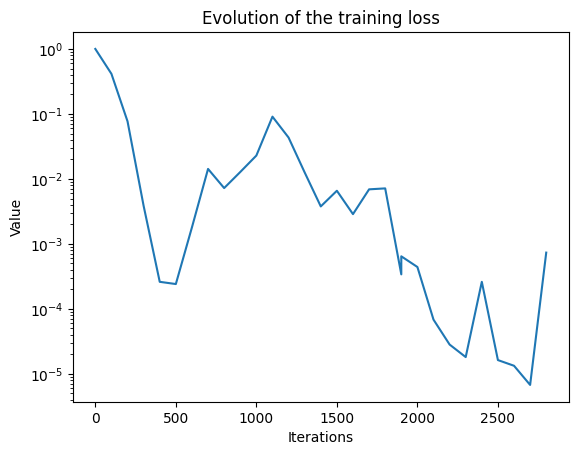

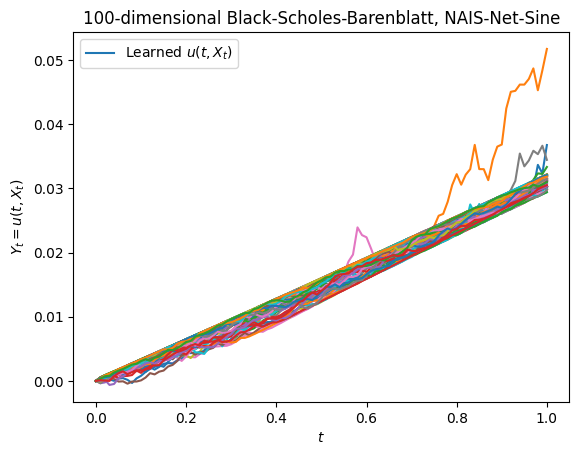

In [25]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
samples = 64

plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')


plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

In [26]:
var = np.abs(np.quantile((Y_pred), 0.05, axis=0))

In [27]:
time_stamps = t_test[0].reshape(101,)


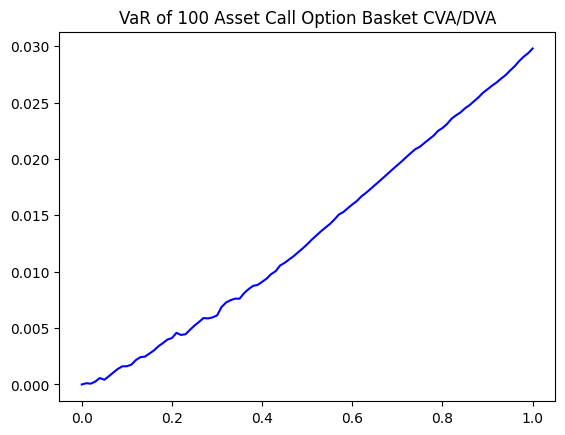

In [28]:
plt.title('VaR of 100 Asset Call Option Basket CVA/DVA')
plt.plot(time_stamps,var,'b',label='VaR')
plt.show()